In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import os, glob, random, itertools
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory


In [3]:

# ---------------------------------------------------------
# 1. Paths & constants
# ---------------------------------------------------------
DATASET_DIR = "/content/drive/MyDrive/ChestXRay2017/chest_xray"   # <-- change if needed
IMG_SIZE    = (224, 224)
BATCH_SIZE  = 32
AUTOTUNE    = tf.data.AUTOTUNE

# ---------------------------------------------------------
# 2. Build a DataFrame of filepaths + clean labels
# ---------------------------------------------------------
def subclass_from_filename(fname: str) -> str:
    """Return 'bacterial', 'viral', or generic 'pneumonia'."""
    lower = fname.lower()
    if "_bacteria" in lower: return "bacterial"
    if "_virus"    in lower: return "viral"
    return "pneumonia"                 # fallback

records = []
for split in ("train", "test"):
    for cls in ("NORMAL", "PNEUMONIA"):
        folder = os.path.join(DATASET_DIR, split, cls)
        for fp in glob.glob(os.path.join(folder, "*.jpeg")):
            label = "normal" if cls == "NORMAL" else subclass_from_filename(fp)
            records.append((fp, label, split))

df = pd.DataFrame(records, columns=["filepath", "label", "split"])
print("Total images:", len(df))
df.head()


Total images: 5876


,filepath,label,split
0,/content/drive/MyDrive/ChestXRay2017/chest_xra...,normal,train
1,/content/drive/MyDrive/ChestXRay2017/chest_xra...,normal,train
2,/content/drive/MyDrive/ChestXRay2017/chest_xra...,normal,train
3,/content/drive/MyDrive/ChestXRay2017/chest_xra...,normal,train
4,/content/drive/MyDrive/ChestXRay2017/chest_xra...,normal,train


In [4]:
# ---------------------------------------------------------
# 3. Create a validation split
# ---------------------------------------------------------
from sklearn.model_selection import train_test_split

train_df = df[df.split=="train"]
train_idx, val_idx = train_test_split(
    train_df.index,
    test_size=0.15,
    stratify=train_df["label"],
    random_state=42)

df.loc[val_idx, "split"] = "val"
print(df["split"].value_counts())


split
train    4464
val       788
test      624
Name: count, dtype: int64


# **Exploratory Data Analysis**

## **Class distribution by split**

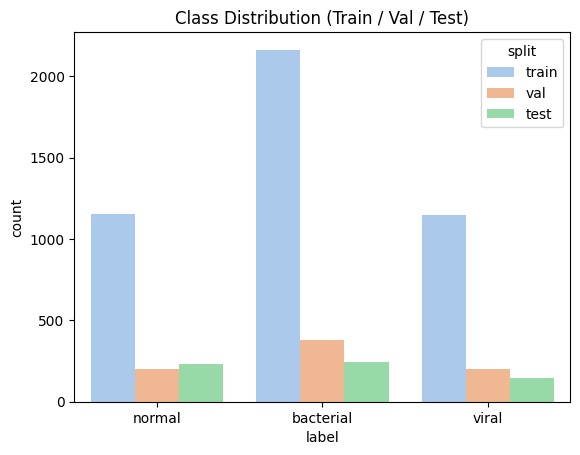

In [ ]:
#   Class distribution by split
sns.countplot(x="label", hue="split", data=df, palette="pastel")
plt.title("Class Distribution (Train / Val / Test)")
plt.show()

## **Random image mosaics for sanity-check**

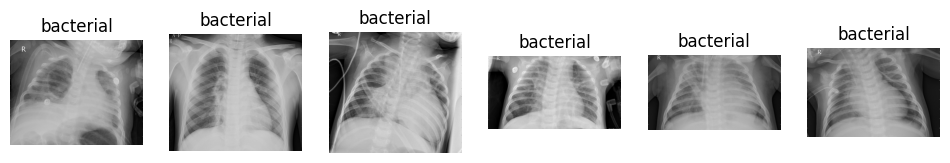

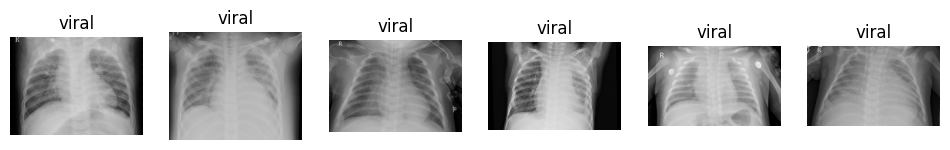

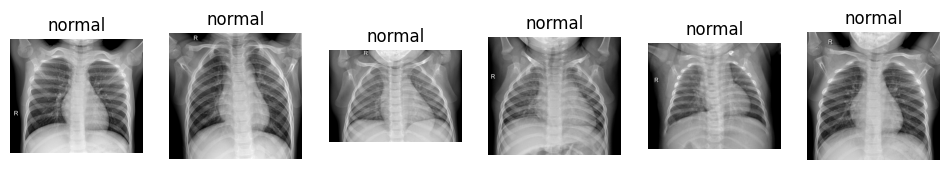

In [6]:
# Random image mosaics for sanity-check
def show_random_samples(lbl="bacterial", n=6):
    sample_paths = df[(df.label==lbl) & (df.split=="train")]["filepath"].sample(n)
    plt.figure(figsize=(12,2))
    for i, fp in enumerate(sample_paths, 1):
        img = plt.imread(fp)
        plt.subplot(1, n, i)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(lbl)
    plt.show()

for lbl in ["bacterial", "viral", "normal"]:
    show_random_samples(lbl)

In [ ]:


#  Image-size statistics
shapes = [tf.image.decode_jpeg(tf.io.read_file(fp), channels=3).shape
          for fp in tqdm(df["filepath"])]
shape_df = pd.DataFrame(shapes, columns=["h","w","c"])
print(shape_df.describe()[["h","w"]])


  0%|          | 0/5876 [00:00<?, ?it/s]

                h            w
count  5876.00000  5876.000000
mean    970.44418  1327.361811
std     383.36124   363.491567
min     127.00000   384.000000
25%     688.00000  1056.000000
50%     887.00000  1280.000000
75%    1187.00000  1560.000000
max    2713.00000  2916.000000


# **Preprocessing**

In [5]:

#  list of filepaths & labels → tf.data.Dataset
label_to_index = {lbl:i for i,lbl in enumerate(sorted(df["label"].unique()))}

def paths_to_dataset(filepaths, labels):
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    # -- map strings → image tensors + one-hot labels
    def _load(path, lbl):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32) / 255.0         # [0,1]
        lbl = tf.one_hot(lbl, depth=len(label_to_index))
        return img, lbl
    ds = ds.map(_load, num_parallel_calls=AUTOTUNE)
    return ds

# Gather splits
train_paths = df[df.split=="train"]["filepath"].tolist()
train_labels= df[df.split=="train"]["label"].map(label_to_index).tolist()

val_paths   = df[df.split=="val"]["filepath"].tolist()
val_labels  = df[df.split=="val"]["label"].map(label_to_index).tolist()

test_paths  = df[df.split=="test"]["filepath"].tolist()
test_labels = df[df.split=="test"]["label"].map(label_to_index).tolist()

# Build datasets
train_ds = paths_to_dataset(train_paths, train_labels)\
             .shuffle(1024).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds   = paths_to_dataset(val_paths, val_labels)\
             .batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_ds  = paths_to_dataset(test_paths, test_labels)\
             .batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("Dataset shapes →", next(iter(train_ds))[0].shape, next(iter(train_ds))[1].shape)


Dataset shapes → (32, 224, 224, 3) (32, 3)


# **Model Implementation**

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time

# Dataset-specific values
NUM_CLASSES = 3
EPOCHS = 15
INPUT_SHAPE = (224, 224, 3)
class_names = ['WithMask', 'WithoutMask', 'MaskWearedIncorrect']

We Build Four models
The four models include:

- DenseNet121 (Transfer Learning)

- Custom CNN (lightweight from scratch)

- MobileNetV2 (Transfer Learning)

- VGG16 (Transfer Learning)

In [7]:

# ----------------------------------------------------------------
# 1. DenseNet121 Model
# ----------------------------------------------------------------
def build_densenet_model(num_classes):
    base = tf.keras.applications.DenseNet121(
        include_top=False, weights="imagenet",
        input_shape=INPUT_SHAPE, pooling="avg")
    base.trainable = False
    inputs = layers.Input(shape=INPUT_SHAPE)
    x = base(inputs, training=False)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

# ----------------------------------------------------------------
# 2. Custom CNN Model
# ----------------------------------------------------------------
def build_custom_cnn(num_classes):
    inputs = layers.Input(shape=INPUT_SHAPE)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

# ----------------------------------------------------------------
# 3. MobileNetV2 Model
# ----------------------------------------------------------------
def build_mobilenet_model(num_classes):
    base = tf.keras.applications.MobileNetV2(
        include_top=False, weights="imagenet",
        input_shape=INPUT_SHAPE, pooling="avg")
    base.trainable = False
    inputs = layers.Input(shape=INPUT_SHAPE)
    x = base(inputs, training=False)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

# ----------------------------------------------------------------
# 4. VGG16 Model
# ----------------------------------------------------------------
def build_vgg16_model(num_classes):
    base = tf.keras.applications.VGG16(
        include_top=False, weights="imagenet",
        input_shape=INPUT_SHAPE, pooling="avg")
    base.trainable = False
    inputs = layers.Input(shape=INPUT_SHAPE)
    x = base(inputs, training=False)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

Train and Evalute the model

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
\n Training DenseNet121...
Epoch 1/15
140/140 - 1547s - 11s/step - accuracy: 0.4301 - auc: 0.6179 - loss: 1.2300 - precision: 0.4524 - recall: 0.3564 - val_accuracy: 0.4365 - val_auc: 0.6027 - val_loss: 1.2767 - val_precision: 0.4407 - val_recall: 0.3769
Epoch 2/15
140/140 - 50s - 357ms/step - accuracy: 0.4321 - auc: 0.6144 - loss: 1.2291 - precision: 0.4645 - recall: 0.3560 - val_accuracy: 0.4721 - val_auc: 0.6587 - val_loss: 1.1274 - val_precision: 0.5030 - val_recall: 0.4213
Epoch 3/15
140/140 - 45s - 321ms/step - accuracy: 0.4899 - auc: 0.6782 - loss: 1.0881 - precision: 0.5286 - recall: 0.4097 - val_accuracy: 0.5025 - val_auc: 0.7006 - val_loss: 1.0244 - val_precision: 0.5374 - val_recall: 0.4467
Epoch 4/15
140/140 - 50s - 360ms/step - accuracy: 0.5296 - auc: 0.7209 - loss: 1.0041 - precision: 0.5793 - recall: 0.4568 - val_accuracy:

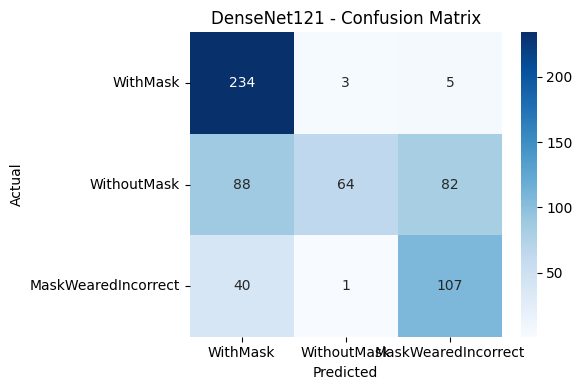

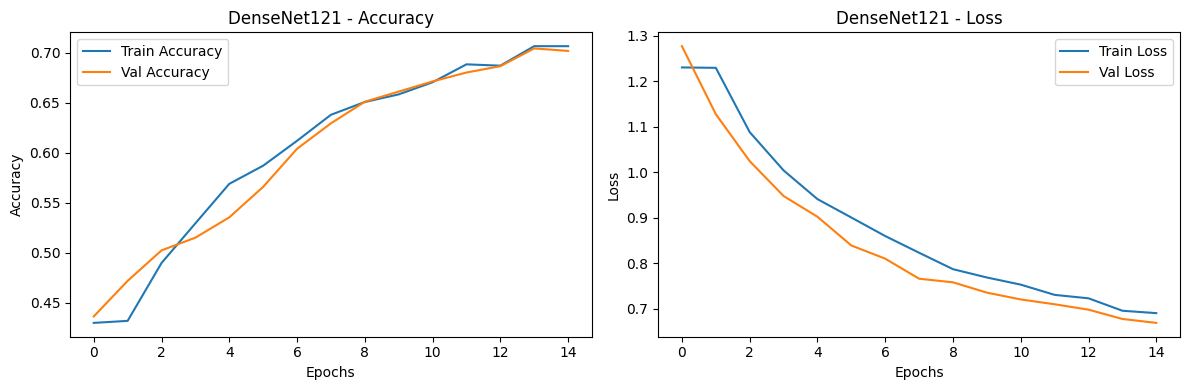

\n Training Custom CNN...
Epoch 1/15
140/140 - 58s - 416ms/step - accuracy: 0.5253 - auc: 0.6735 - loss: 1.0133 - precision: 0.5494 - recall: 0.2218 - val_accuracy: 0.4848 - val_auc: 0.5928 - val_loss: 1.2514 - val_precision: 0.4848 - val_recall: 0.4848
Epoch 2/15
140/140 - 70s - 499ms/step - accuracy: 0.4850 - auc: 0.5666 - loss: 1.1485 - precision: 0.4055 - recall: 0.0961 - val_accuracy: 0.4848 - val_auc: 0.5951 - val_loss: 1.0761 - val_precision: 0.4784 - val_recall: 0.4505
Epoch 3/15
140/140 - 82s - 586ms/step - accuracy: 0.4848 - auc: 0.5821 - loss: 1.0810 - precision: 0.4468 - recall: 0.0903 - val_accuracy: 0.4848 - val_auc: 0.6030 - val_loss: 1.0770 - val_precision: 0.4837 - val_recall: 0.4695
Epoch 4/15
140/140 - 48s - 345ms/step - accuracy: 0.4877 - auc: 0.6106 - loss: 1.0679 - precision: 0.4910 - recall: 0.1102 - val_accuracy: 0.4860 - val_auc: 0.6236 - val_loss: 1.0604 - val_precision: 0.4909 - val_recall: 0.4467
Epoch 5/15
140/140 - 48s - 339ms/step - accuracy: 0.4931 - auc

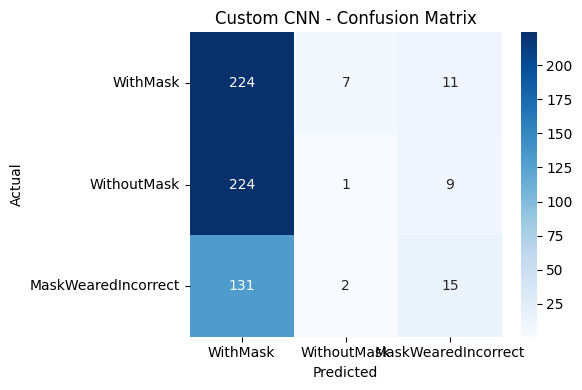

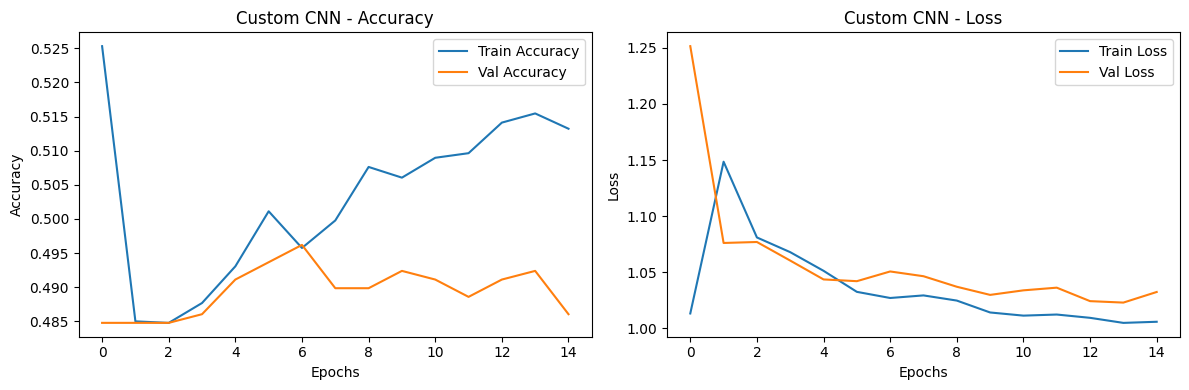

\n Training MobileNetV2...
Epoch 1/15
140/140 - 74s - 526ms/step - accuracy: 0.4987 - auc: 0.6950 - loss: 1.0723 - precision: 0.5254 - recall: 0.4330 - val_accuracy: 0.4975 - val_auc: 0.6939 - val_loss: 1.1075 - val_precision: 0.5392 - val_recall: 0.4708
Epoch 2/15
140/140 - 60s - 428ms/step - accuracy: 0.5325 - auc: 0.7203 - loss: 1.0117 - precision: 0.5793 - recall: 0.4581 - val_accuracy: 0.5317 - val_auc: 0.7514 - val_loss: 0.9305 - val_precision: 0.6164 - val_recall: 0.4772
Epoch 3/15
140/140 - 48s - 342ms/step - accuracy: 0.6017 - auc: 0.7855 - loss: 0.8788 - precision: 0.6504 - recall: 0.5293 - val_accuracy: 0.6015 - val_auc: 0.7955 - val_loss: 0.8443 - val_precision: 0.6606 - val_recall: 0.5089
Epoch 4/15
140/140 - 44s - 313ms/step - accuracy: 0.6306 - auc: 0.8081 - loss: 0.8342 - precision: 0.6667 - recall: 0.5627 - val_accuracy: 0.6624 - val_auc: 0.8299 - val_loss: 0.7772 - val_precision: 0.7129 - val_recall: 0.5546
Epoch 5/15
140/140 - 44s - 315ms/step - accuracy: 0.6611 - au

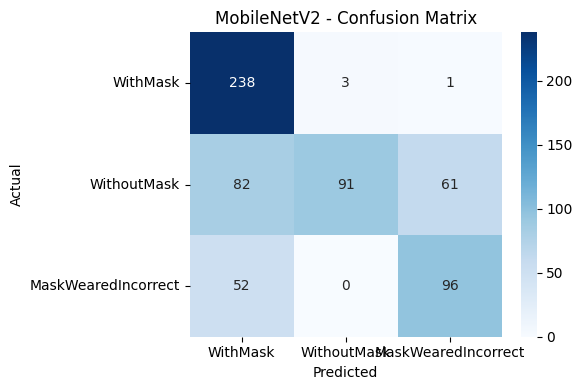

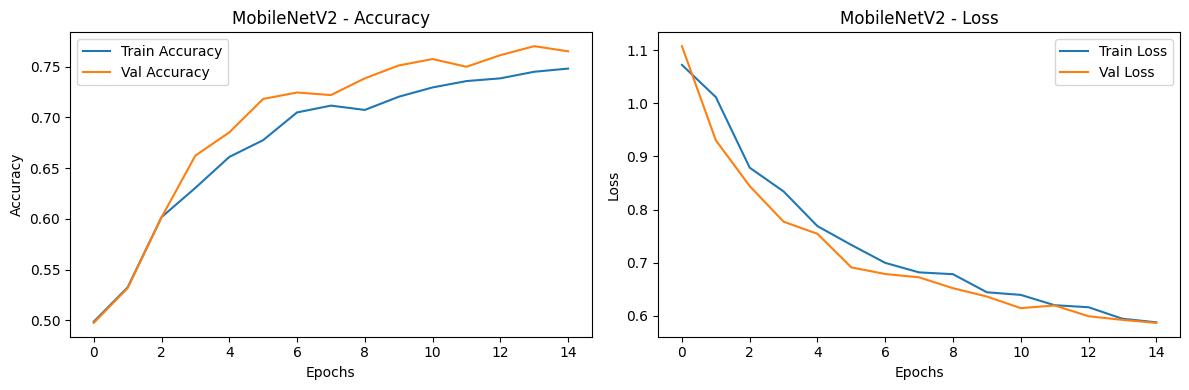

\n Training VGG16...
Epoch 1/15
140/140 - 86s - 613ms/step - accuracy: 0.4328 - auc: 0.6011 - loss: 1.0734 - precision: 0.5085 - recall: 0.1333 - val_accuracy: 0.4848 - val_auc: 0.6287 - val_loss: 1.0510 - val_precision: 0.4841 - val_recall: 0.3680
Epoch 2/15
140/140 - 53s - 381ms/step - accuracy: 0.4628 - auc: 0.6138 - loss: 1.0694 - precision: 0.4911 - recall: 0.2092 - val_accuracy: 0.4848 - val_auc: 0.6588 - val_loss: 1.0409 - val_precision: 0.4895 - val_recall: 0.4416
Epoch 3/15
140/140 - 53s - 381ms/step - accuracy: 0.4691 - auc: 0.6178 - loss: 1.0671 - precision: 0.4702 - recall: 0.1960 - val_accuracy: 0.4848 - val_auc: 0.6837 - val_loss: 1.0278 - val_precision: 0.4966 - val_recall: 0.4670
Epoch 4/15
140/140 - 53s - 376ms/step - accuracy: 0.4727 - auc: 0.6373 - loss: 1.0505 - precision: 0.4948 - recall: 0.2126 - val_accuracy: 0.4848 - val_auc: 0.7018 - val_loss: 1.0140 - val_precision: 0.5155 - val_recall: 0.4645
Epoch 5/15
140/140 - 48s - 343ms/step - accuracy: 0.4973 - auc: 0.6

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


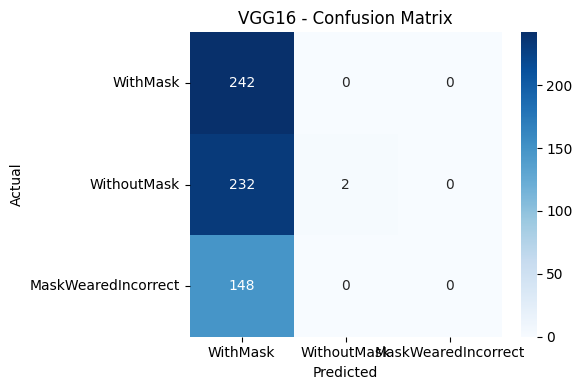

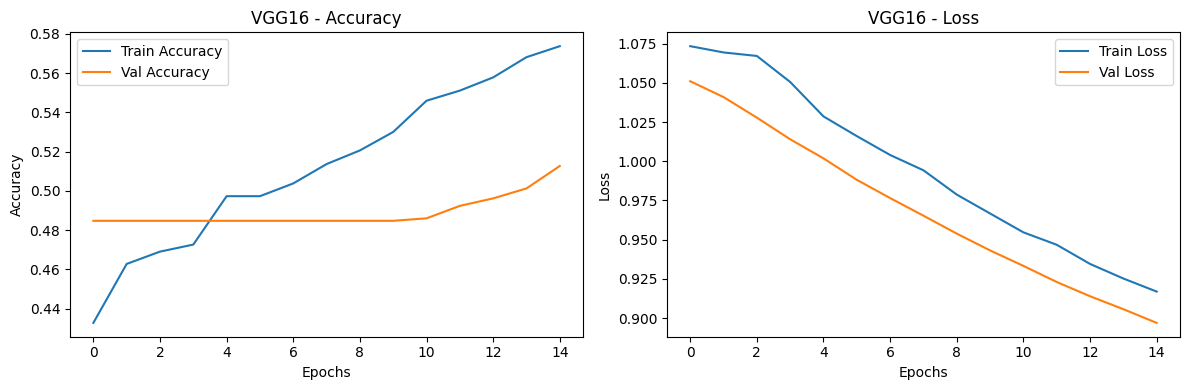

In [8]:

# Compile and train
def compile_and_train(model, name, train_ds, val_ds, epochs=EPOCHS):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy',
                 tf.keras.metrics.AUC(name='auc'),
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )
    print(f"\\n Training {name}...")
    start_time = time.time()
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=2)
    train_time = time.time() - start_time
    print(f" Training time for {name}: {train_time:.2f} seconds")
    return model, history, train_time

# Train and evaluate all models
models_to_train = {
    "DenseNet121": build_densenet_model(NUM_CLASSES),
    "Custom CNN": build_custom_cnn(NUM_CLASSES),
    "MobileNetV2": build_mobilenet_model(NUM_CLASSES),
    "VGG16": build_vgg16_model(NUM_CLASSES)
}

model_histories = {}

for model_name, model_instance in models_to_train.items():
    model, history, train_time = compile_and_train(model_instance, model_name, train_ds, val_ds)

    # Evaluation
    print(f"\\n Evaluating {model_name}...")
    start_test = time.time()
    y_true, y_pred = [], []

    for x_batch, y_batch in test_ds:
        preds = model.predict(x_batch)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(np.argmax(y_batch.numpy(), axis=1))

    test_time = time.time() - start_test
    print(f" Testing time: {test_time:.2f} seconds")

    print(" Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
